In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.mixture import GaussianMixture

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customer-segmentation/bank_transactions.csv


In [2]:
df = pd.read_csv('/kaggle/input/bank-customer-segmentation/bank_transactions.csv')
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [4]:
df.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

The columns with NA values account for less than 1% of our data, so I'm just going to drop them. I don't understand why CustAccountBalance would have unknown values, the only thought I have is that they have no account, or a total balance of 0, so if I kept them, I would probaby just fill with 0 instead of a median value. CustGender could matter, that's something I'd have to explore before considering if I would want to nn impute this, and the location could matter as well, with the same deal. However, we have enough data to ignore doing this.

In [5]:
df = df.dropna()
df['CustomerDOB'].value_counts()

1/1/1800    56292
1/1/89        809
1/1/90        784
6/8/91        698
1/1/91        665
            ...  
2/12/51         1
20/3/52         1
26/9/47         1
4/10/41         1
24/10/44        1
Name: CustomerDOB, Length: 17233, dtype: int64

There are a lot of birthdates on January 1st, which seems  alittle suspicious. There's also a lot of customers birth DOB on 1/1/1800, having 70x the number as the next highest date. This is probably some default the bank has where this information is unknown, althought that is a little suspicous. I'll remove them.

In [6]:
df = df.loc[~(df['CustomerDOB'] == '1/1/1800')]
df['CustomerDOB'].value_counts()

1/1/89      809
1/1/90      784
6/8/91      698
1/1/91      665
1/1/92      631
           ... 
23/2/05       1
28/11/42      1
23/9/49       1
14/3/40       1
24/10/44      1
Name: CustomerDOB, Length: 17232, dtype: int64

In [7]:
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], format = '%d/%m/%y')
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [8]:
df.loc[df['CustomerDOB'].dt.year >= 2021, ['CustomerDOB']] -= pd.DateOffset(years = 100)
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [9]:
df['TransactionDate'].value_counts()

7/8/16      26022
13/8/16     25478
4/9/16      25392
6/8/16      25267
3/9/16      25102
10/9/16     24424
11/9/16     24308
14/8/16     24262
15/8/16     23001
21/8/16     21655
2/9/16      21541
12/8/16     21115
1/9/16      21019
9/8/16      20489
11/8/16     20461
8/9/16      20447
10/8/16     20352
9/9/16      20308
27/8/16     20130
20/8/16     20031
5/9/16      20024
7/9/16      19904
5/8/16      19890
28/8/16     19874
17/8/16     19763
8/8/16      19647
2/8/16      19631
4/8/16      19428
13/9/16     19391
12/9/16     19385
3/8/16      19274
1/8/16      19213
16/8/16     19065
14/9/16     18573
15/9/16     18482
6/9/16      18440
31/8/16     18368
18/8/16     18302
19/8/16     17394
22/8/16     17339
25/8/16     17335
24/8/16     16647
26/8/16     16463
30/8/16     16119
23/8/16     16056
29/8/16     15534
18/9/16     13902
26/9/16     11541
25/9/16      7766
27/9/16      6910
22/9/16      6350
21/10/16     3408
23/9/16      3276
30/9/16      1822
16/10/16        2
Name: Tran

All the trnasactions took place in a roughly two month period from August to October, this could account for the low transaction frequency

In [10]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format = '%d/%m/%y')

Text(0.5, 1.0, 'Number of transactions in each month')

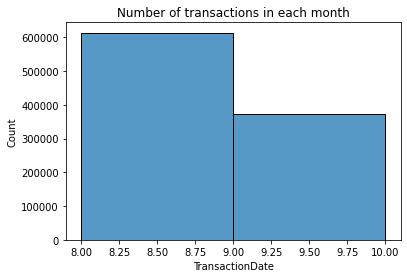

In [11]:
sns.histplot(x = df['TransactionDate'].dt.month, bins = 3, binwidth = 1)
plt.title('Number of transactions in each month')

In [12]:
df['Age'] = (pd.to_datetime('today') - df['CustomerDOB'])/np.timedelta64(1, 'Y')
df['DaysSinceTransaction'] = (pd.to_datetime('today') - df['TransactionDate'])/np.timedelta64(1, 'D')
df['DaysSinceTransaction'] = df['DaysSinceTransaction'] - df['DaysSinceTransaction'].min()
temp = df[['CustomerID', 'TransactionID']].groupby(by = 'CustomerID', as_index = False, sort = False).count().reset_index()

In [13]:
temp = temp.drop(columns = 'index')
temp.rename(columns = {'TransactionID' : 'TransactionFrequency'})
df = df.merge(right = temp, on = 'CustomerID')
df.head()

,TransactionID_x,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age,DaysSinceTransaction,TransactionID_y
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02,143207,25.0,27.803629,80.0,1
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-08-02,141858,27999.0,64.573720,80.0,1
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-08-02,142712,459.0,24.926089,80.0,1
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-08-02,142714,2060.0,48.127113,80.0,2
4,T391139,C5342380,1979-05-29,M,MUMBAI,3195.78,2016-08-13,194148,878.4,42.424053,69.0,2


In [14]:
df = df.rename(columns = {'TransactionID_y' : 'TransactionFrequency',
                         'DaysSinceTransaction' : 'Recency'})

In [15]:
rmf = df.drop(columns = ['CustGender', 'CustLocation', 'CustLocation',
                         'CustAccountBalance', 'TransactionTime', 'Age']
             ).groupby(by = 'CustomerID').agg({'Recency' : 'min',
                                               'TransactionFrequency': 'first',
                                               'TransactionAmount (INR)' : 'mean'})
df = df.rename(columns = {'TransactionAmount (INR)' : 'AverageTransactionAmount'})
rmf = rmf.rename(columns = {'TransactionAmount (INR)' : 'AverageTransactionAmount'})
rmf.head()

,Recency,TransactionFrequency,AverageTransactionAmount
CustomerID,,,
C1010011,25.0,2,2553.0
C1010012,68.0,1,1499.0
C1010014,75.0,2,727.5
C1010018,36.0,1,30.0
C1010024,64.0,1,5000.0


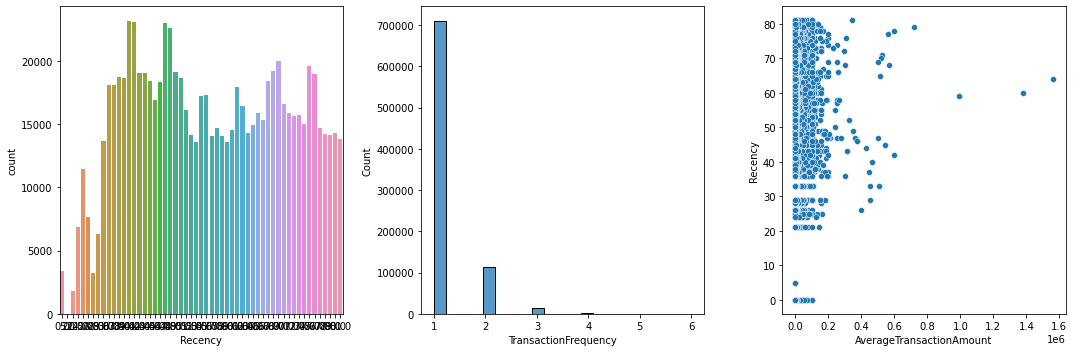

In [16]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes = axes.flatten()

sns.countplot(x = 'Recency', data = rmf, ax = axes[0])
sns.histplot(x = 'TransactionFrequency', data = rmf, ax = axes[1])
sns.scatterplot(x = 'AverageTransactionAmount', y = 'Recency', data = rmf, ax = axes[2])
plt.tight_layout()

In [17]:
def recency_score(value, quartiles):
    if value < quartiles[0.25]:
        return 4
    if value < quartiles[0.5]:
        return 3
    if value < quartiles[.75]:
        return 2
    else:
        return 1

def monetary_score(value, quartiles):
    if value < quartiles[0.25]:
        return 1
    if value < quartiles[0.5]:
        return 2
    if value < quartiles[0.75]:
        return 3
    else:
        return 4
    
quartiles = rmf.quantile([0.25, 0.5, 0.75]).to_dict()

rmf['recency_score'] = rmf['Recency'].apply(recency_score, quartiles = quartiles['Recency'],)
rmf['frequency_score'] = rmf['TransactionFrequency'].astype(int)
rmf.loc[rmf['frequency_score'] > 4, 'frequency_score'] = 4
rmf['monetary_score'] = rmf['AverageTransactionAmount'].apply(monetary_score, quartiles = quartiles['AverageTransactionAmount'],)
rmf['total_score'] = rmf['recency_score'] + rmf['frequency_score'] + rmf['monetary_score']

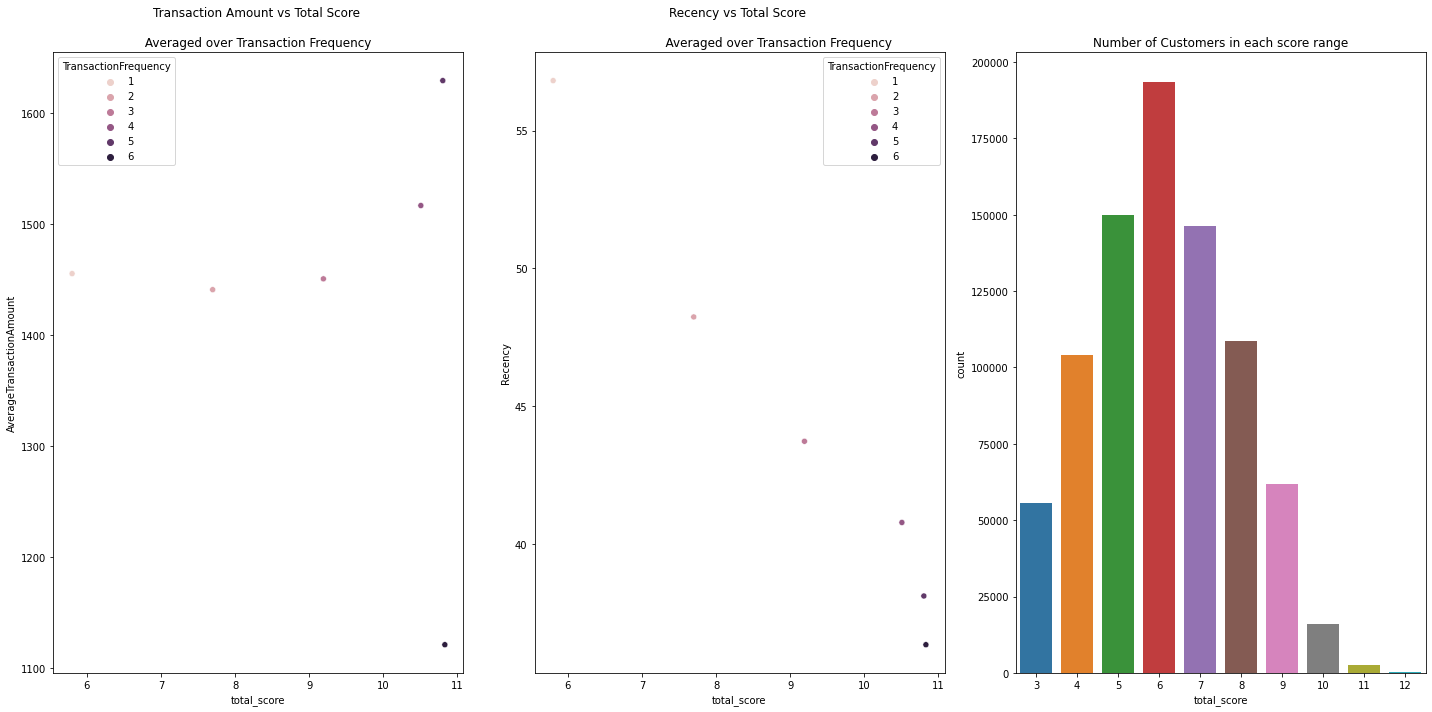

In [18]:
fig, axes = plt.subplots(1, 3, figsize = (20, 10))
axes = axes.flatten()

recency = rmf.groupby(by = 'TransactionFrequency').mean().reset_index()
avg_amount = rmf.groupby(by = 'TransactionFrequency').mean().reset_index()


sns.scatterplot(x = 'total_score', y = 'AverageTransactionAmount', hue = 'TransactionFrequency',
            data = avg_amount, ax = axes[0])
axes[0].set_title('''Transaction Amount vs Total Score 
                  \n Averaged over Transaction Frequency ''')
sns.scatterplot(x = 'total_score', y = 'Recency', data = recency, hue = 'TransactionFrequency',
            ax = axes[1])
axes[1].set_title('''Recency vs Total Score \n
                    Averaged over Transaction Frequency''')
sns.countplot(x = 'total_score', data = rmf, ax = axes[2])
axes[2].set_title('Number of Customers in each score range')
plt.tight_layout()

In [19]:
rmf[rmf.total_score == 12].count()

Recency                     273
TransactionFrequency        273
AverageTransactionAmount    273
recency_score               273
frequency_score             273
monetary_score              273
total_score                 273
dtype: int64

The average transaction is mostly constant for the transaction frequency range, except for the sharp increase in the range of 4 - 5 transactions over the three months, and a sudden sharp decrease for the most frequent (and significantly rarer) 6 transactions over that interval. Since 4 - 6 transactions all give a frequency score of 4, one would expect that they share the same average total score, however this is clearly not the case, with the average total score increasing from 4-6 transactions.

When we look at the recency, we see that the average recency decreases with the average frequency (which shouldn't be shocking), which will compensate for the reduced average transactional amount.

In [20]:
rmf.groupby(by = 'total_score').describe().T

total_score                               3              4              5   \
Recency                  count  55754.000000  104189.000000  149813.000000   
                         mean      74.438856      67.996286      61.921415   
                         std        3.999220       7.675152      11.281041   
                         min       68.000000      55.000000      43.000000   
                         25%       71.000000      61.000000      52.000000   
                         50%       74.000000      68.000000      62.000000   
                         75%       78.000000      75.000000      72.000000   
                         max       81.000000      81.000000      81.000000   
TransactionFrequency     count  55754.000000  104189.000000  149813.000000   
                         mean       1.000000       1.013418       1.041759   
                         std        0.000000       0.115057       0.200904   
                         min        1.000000       1.000000       1.000000   
                         25%        1.000000       1.000000       1.000000   
                         50%        1.000000       1.000000       1.000000   
                         75%        1.000000       1.000000       1.000000   
                         max        1.000000       2.000000       3.000000   
AverageTransactionAmount count  55754.000000  104189.000000  149813.000000   
                         mean      77.286559     187.954505     381.323779   
                         std       48.455649     127.997460     313.784053   
                         min        0.000000       0.000000       0.000000   
                         25%       35.000000      70.000000     110.000000   
                         50%       70.000000     185.710000     295.000000   
                         75%      110.000000     290.000000     582.000000   
                         max      179.950000     474.990000    1175.400000   
recency_score            count  55754.000000  104189.000000  149813.000000   
                         mean       1.000000       1.476634       1.943716   
                         std        0.000000       0.499456       0.827301   
                         min        1.000000       1.000000       1.000000   
                         25%        1.000000       1.000000       1.000000   
                         50%        1.000000       1.000000       2.000000   
                         75%        1.000000       2.000000       3.000000   
                         max        1.000000       2.000000       3.000000   
frequency_score          count  55754.000000  104189.000000  149813.000000   
                         mean       1.000000       1.013418       1.041759   
                         std        0.000000       0.115057       0.200904   
                         min        1.000000       1.000000       1.000000   
                         25%        1.000000       1.000000       1.000000   
                         50%        1.000000       1.000000       1.000000   
                         75%        1.000000       1.000000       1.000000   
                         max        1.000000       2.000000       3.000000   
monetary_score           count  55754.000000  104189.000000  149813.000000   
                         mean       1.000000       1.509948       2.014525   
                         std        0.000000       0.499903       0.831747   
                         min        1.000000       1.000000       1.000000   
                         25%        1.000000       1.000000       1.000000   
                         50%        1.000000       2.000000       2.000000   
                         75%        1.000000       2.000000       3.000000   
                         max        1.000000       2.000000       3.000000   

total_score                                6             7              8   \
Recency                  count  193497.000000  1.464410e+05  108547.000000   
                     

Unsurpisingly, due to the low frequency of transactions, most people fall around a total score of the 5 - 7  out of 12. There are similar numbers of 3, 4 to 8, 9, and very few 10 and above. About 1% of the people have a score above 10. Moving on to clustering:

In [21]:
df.head()

,TransactionID_x,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,AverageTransactionAmount,Age,Recency,TransactionFrequency
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02,143207,25.0,27.803629,80.0,1
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-08-02,141858,27999.0,64.573720,80.0,1
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-08-02,142712,459.0,24.926089,80.0,1
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-08-02,142714,2060.0,48.127113,80.0,2
4,T391139,C5342380,1979-05-29,M,MUMBAI,3195.78,2016-08-13,194148,878.4,42.424053,69.0,2


In [22]:
df_cluster = df.drop(columns = ['CustomerID', 'CustomerDOB', 'TransactionDate', 'TransactionTime'])
df_cluster['CustGender'] = df_cluster['CustGender'].map(lambda x: 1 if x == 'F' else 0)
locations = df_cluster.CustLocation.unique()
locations = {place : idx for idx, place in enumerate(locations)}
df_cluster['CustLocation'] = df_cluster['CustLocation'].map(locations)
df_cluster.head()

,TransactionID_x,CustGender,CustLocation,CustAccountBalance,AverageTransactionAmount,Age,Recency,TransactionFrequency
0,T1,1,0,17819.05,25.0,27.803629,80.0,1
1,T2,0,1,2270.69,27999.0,64.573720,80.0,1
2,T3,1,2,17874.44,459.0,24.926089,80.0,1
3,T4,1,2,866503.21,2060.0,48.127113,80.0,2
4,T391139,0,2,3195.78,878.4,42.424053,69.0,2


In [23]:
#df_cluster.rename(columns = {'TransactionAmount (INR)' : 'AverageTransactionAmount'})
numeric_to_locations = {idx : location for idx, location in enumerate(locations.keys())}
df_cluster['CustLocation'].value_counts().head(10)

2     97679
22    77751
14    76380
8     70518
18    67335
35    31675
19    27500
7     24493
45    21819
13    21006
Name: CustLocation, dtype: int64

There are over 1000 locations, so I believe they correspond to the bank's actual location as opposed to a providence. I'm going to just take the tenth largest location, as KMeans explodes with n

In [24]:
location_9 = df_cluster.loc[df_cluster.CustLocation == 9]
location_9.head()

,TransactionID_x,CustGender,CustLocation,CustAccountBalance,AverageTransactionAmount,Age,Recency,TransactionFrequency
14,T11,0,9,48429.49,259.0,39.275460,80.0,2
43,T793207,0,9,6786.39,16.0,29.599696,46.0,2
352,T289,0,9,390.04,567.0,35.102889,0.0,1
384,T317,0,9,5802.91,695.0,51.511166,0.0,1
390,T322,0,9,176012.36,222.0,36.419823,0.0,1


In [25]:
del(df)
del(rmf)

I'm going to ignore global clustering, which may give insights to topics such as rural vs urban, and may give insights to demographics, ie is there a difference in banking between more conservative and more liberals, or with respect to religiousosity. The dataset is too large for batchedkmeans to find clusters in a reasonable time.

In [26]:
ss = StandardScaler()
ct = ColumnTransformer([('Standard Scaling', ss, 
                    ['CustAccountBalance', 'AverageTransactionAmount',
                    'Age', 'Recency'])], remainder = 'passthrough')

clusters = range(2, 10)
X = location_9.drop(columns = ['TransactionID_x', 'CustLocation'])
X = ct.fit_transform(X)

In [27]:
def plt_silhouette(clusters, clusterer):
    #This silhouette analysis is from SKLearn : https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    for cluster in clusters:
        fig, ax = plt.subplots(1, 1, figsize = (10, 10))

        ax.set_xlim([0, 1])
        ax.set_ylim([0, len(X) + (cluster + 1) * 10])
        
        if clusterer == MiniBatchKMeans:
            md = MiniBatchKMeans(n_clusters = cluster)
            preds = md.fit_predict(X)
            md_name = 'MiniBatchKMeans'
        else:
            md = GaussianMixture(n_components = cluster)
            preds = md.fit_predict(X)
            md_name = 'GaussianMixture'
        
        sil_average = silhouette_score(X, preds)
        print(f'For {cluster} clusters,\n the average silhouette score is {sil_average}')
        sample_sil = silhouette_samples(X, preds)
        y_lower = 10

        for i in range(cluster):
            cluster_sil = sample_sil[preds == i]
            cluster_sil.sort()
            size_cluster = cluster_sil.shape[0]
            y_upper = y_lower + size_cluster
            color = cm.nipy_spectral(float(i) / cluster)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                            0,
                            cluster_sil,
                            facecolor = color,
                            edgecolor = color)
            ax.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
            y_lower = y_upper + 10
            ax.axvline(x = sil_average, color = 'red', linestyle = '--')
            ax.set_yticks([])
            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.set_title(f'Silhouette analysis using {md_name} for {cluster} clusters', fontweight = 'bold')

For 2 clusters,
 the average silhouette score is 0.39739982338875757
For 3 clusters,
 the average silhouette score is 0.29357739735797095
For 4 clusters,
 the average silhouette score is 0.2383325624497458
For 5 clusters,
 the average silhouette score is 0.29234443437252083
For 6 clusters,
 the average silhouette score is 0.22710583689750874
For 7 clusters,
 the average silhouette score is 0.20152982607525127
For 8 clusters,
 the average silhouette score is 0.19551051660837024
For 9 clusters,
 the average silhouette score is 0.22493625345604318


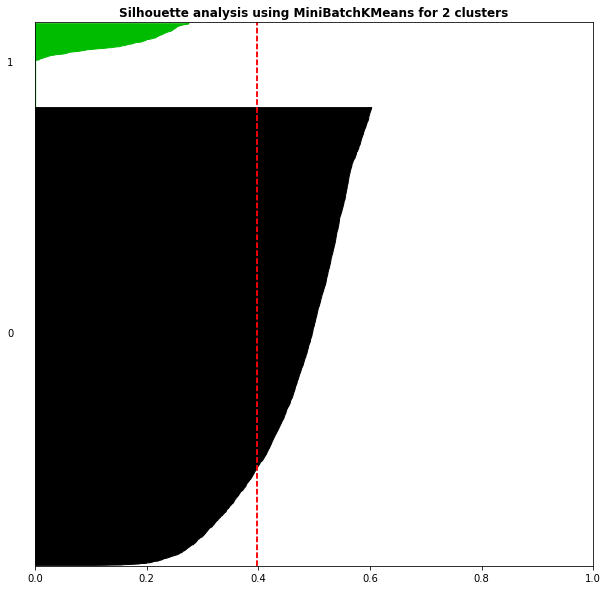

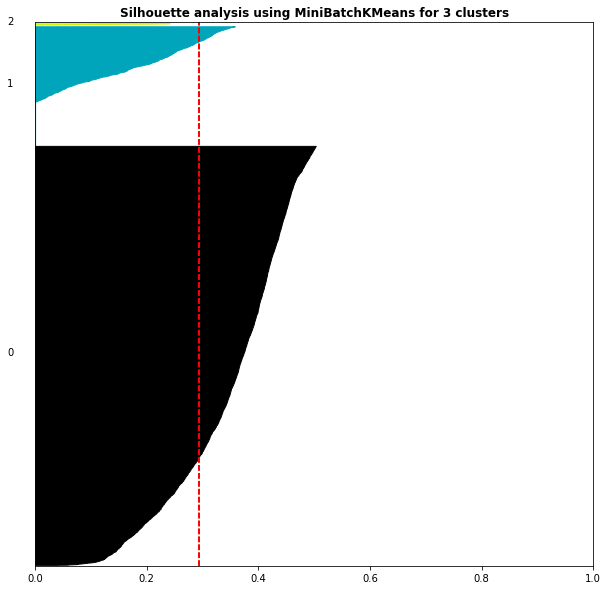

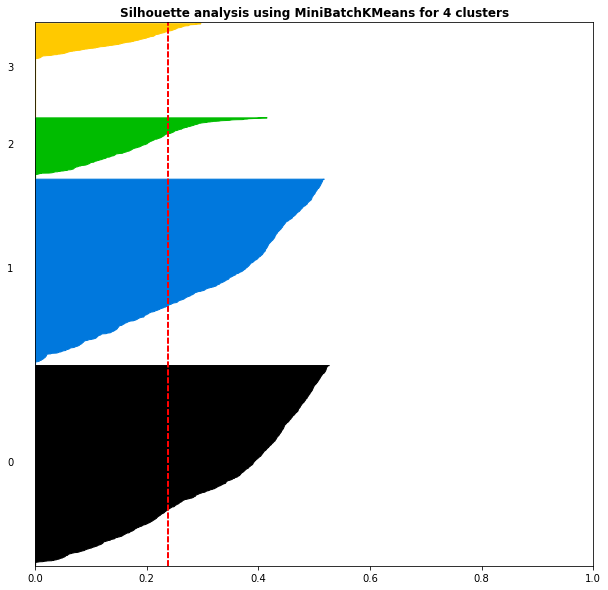

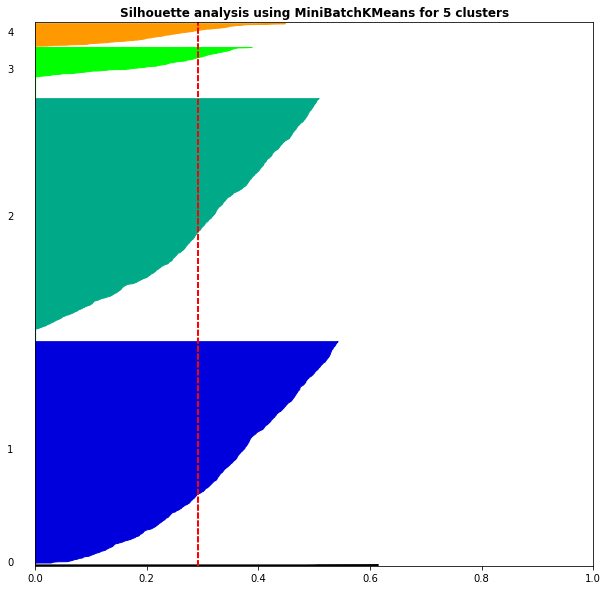

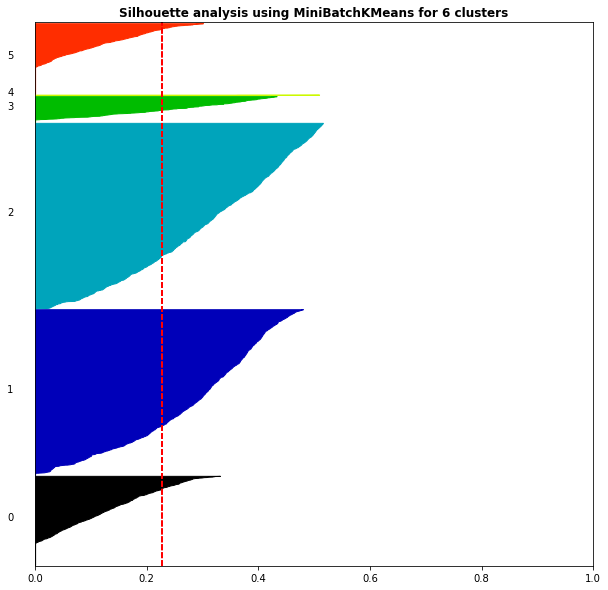

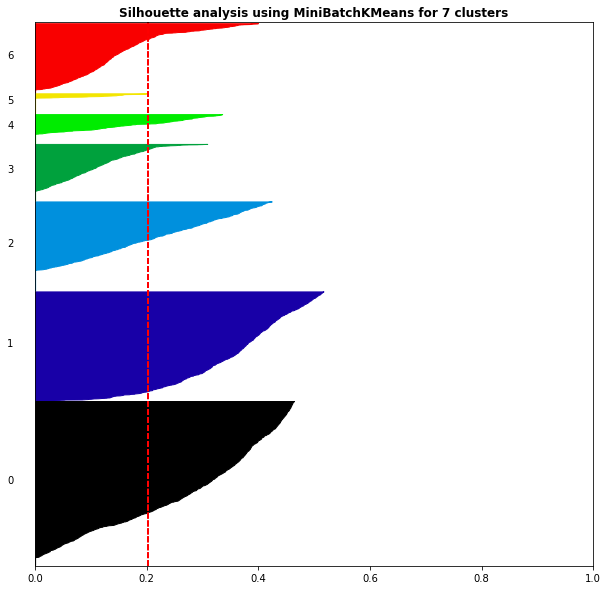

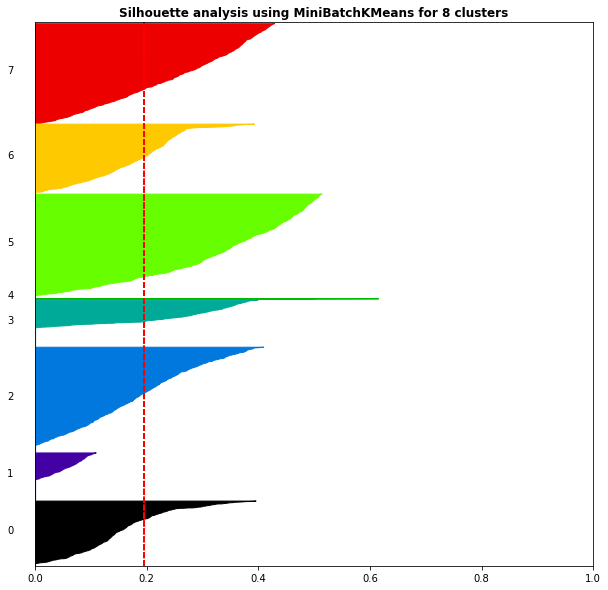

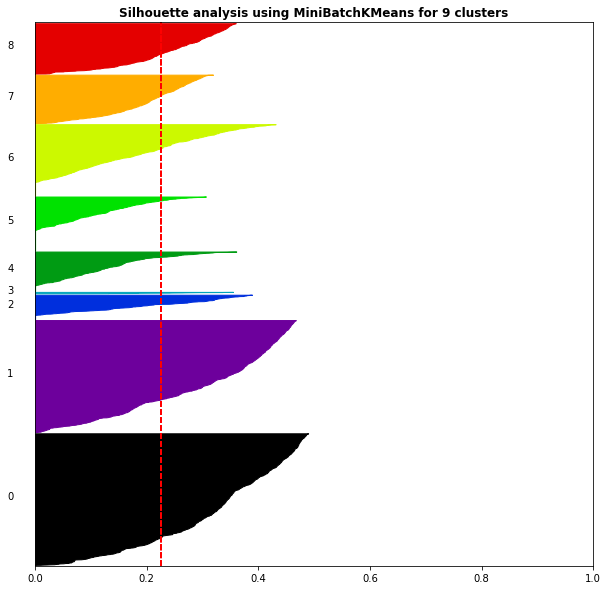

In [28]:
plt_silhouette(clusters, MiniBatchKMeans)

For 2 clusters,
 the average silhouette score is 0.2696129241891418
For 3 clusters,
 the average silhouette score is 0.2266418030578926
For 4 clusters,
 the average silhouette score is 0.015437003762344076
For 5 clusters,
 the average silhouette score is 0.10431872120878218
For 6 clusters,
 the average silhouette score is 0.10567592237704374
For 7 clusters,
 the average silhouette score is 0.09341513065428413
For 8 clusters,
 the average silhouette score is 0.06878707418541555
For 9 clusters,
 the average silhouette score is 0.025606202386014704


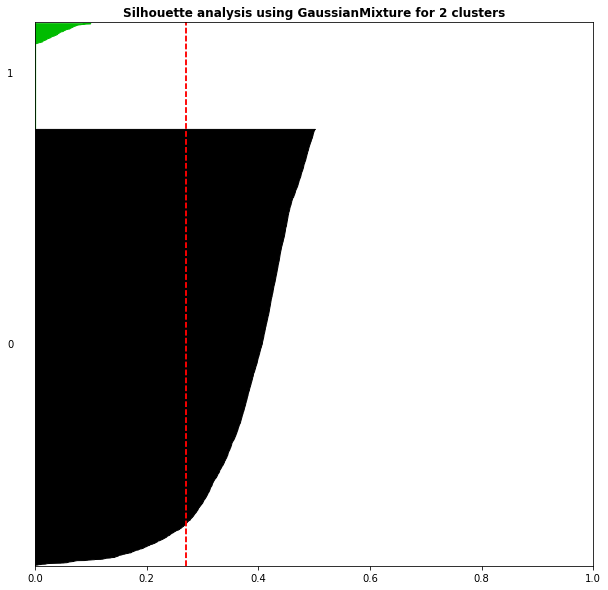

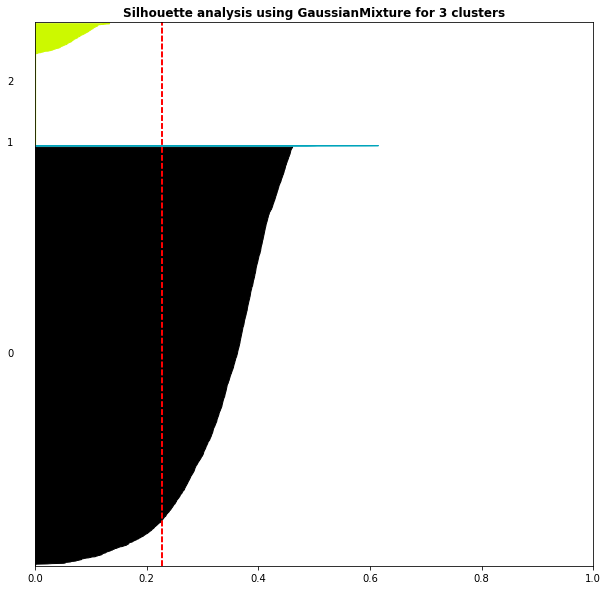

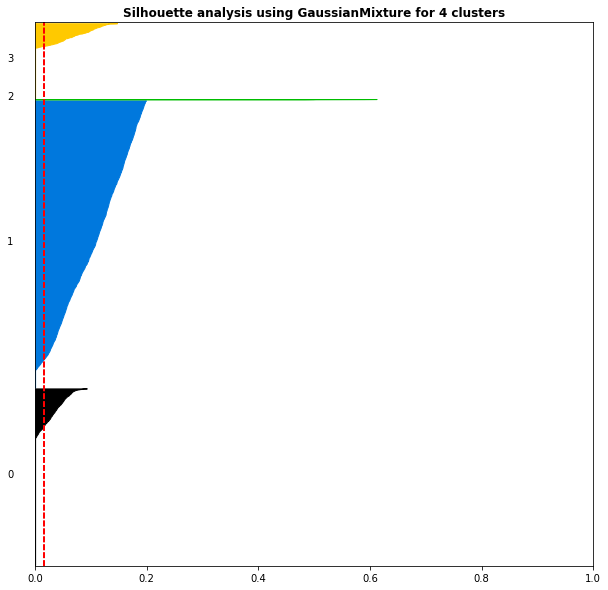

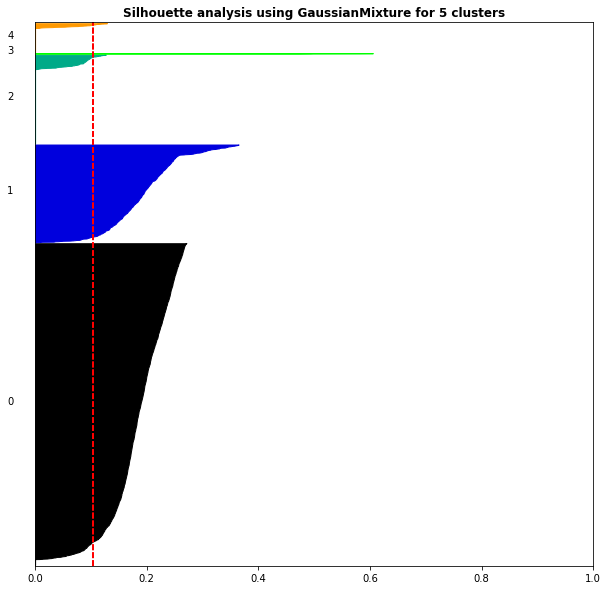

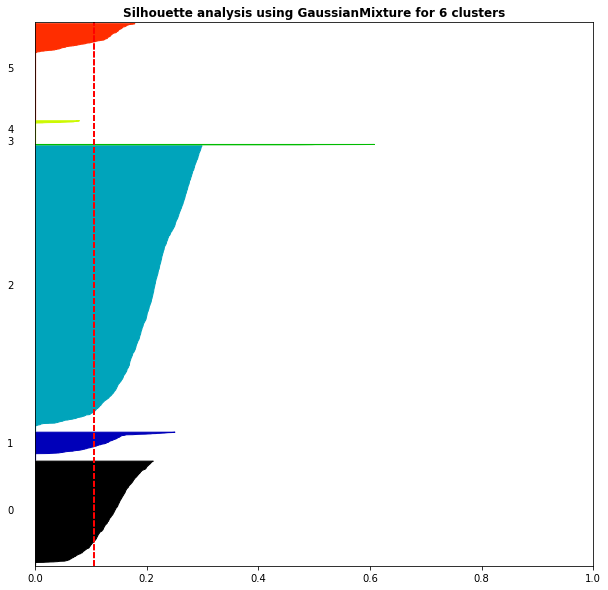

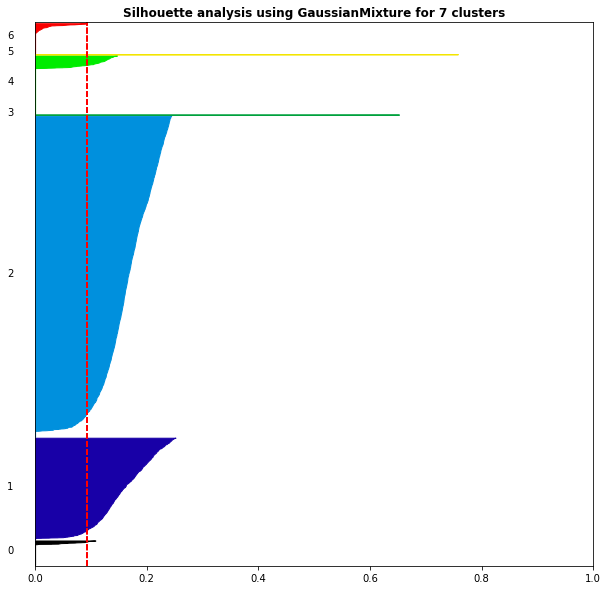

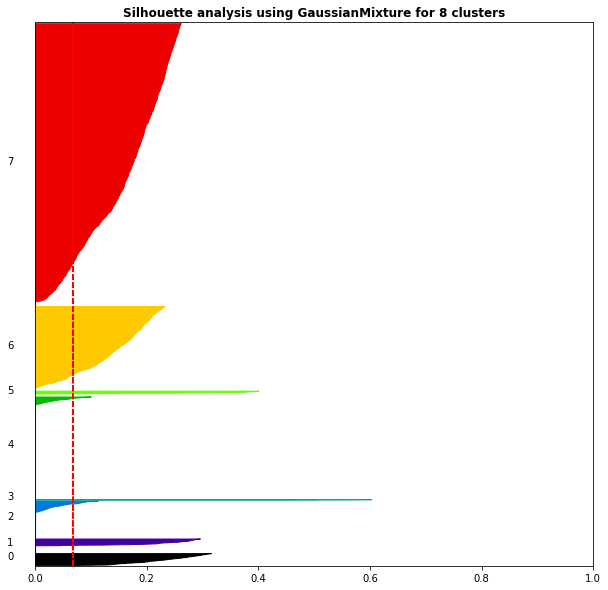

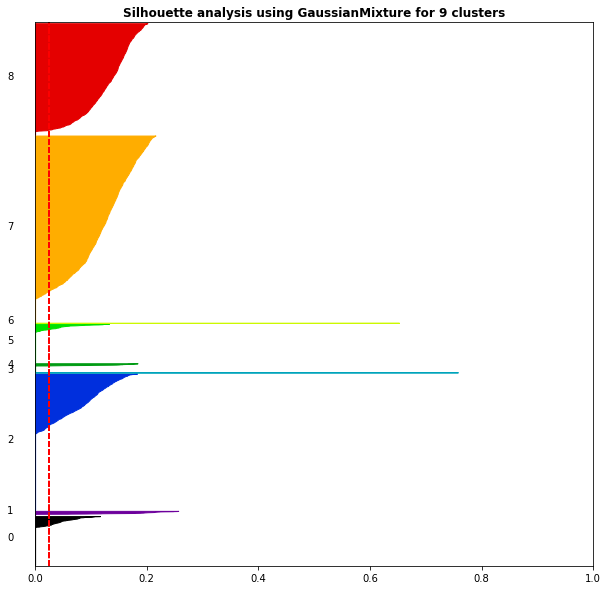

In [29]:
plt_silhouette(clusters, GaussianMixture)

With Silhouette score, you'd like  for the the groups to be of roughly equal sizes, and all of the clusters should have at least the average silhouette score. With regards to this, KMeans with two clusters seem to be the best, having a signifcantly higher silhouette score, and while one cluster is significantly smaller than the other, this is probably due to the large imbalance in the frequency of transactions. Let's see what happens when we exclude the frequency

For 2 clusters,
 the average silhouette score is 0.3034886530122184
For 3 clusters,
 the average silhouette score is 0.33922297635006177
For 4 clusters,
 the average silhouette score is 0.2276261173144448
For 5 clusters,
 the average silhouette score is 0.3547981994951086
For 6 clusters,
 the average silhouette score is 0.2564583779012366
For 7 clusters,
 the average silhouette score is 0.23192464620894232
For 8 clusters,
 the average silhouette score is 0.2662676040280255
For 9 clusters,
 the average silhouette score is 0.24383139462024056


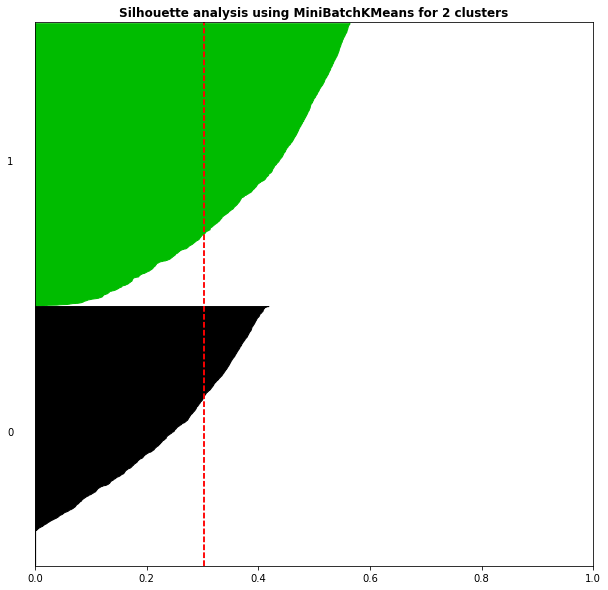

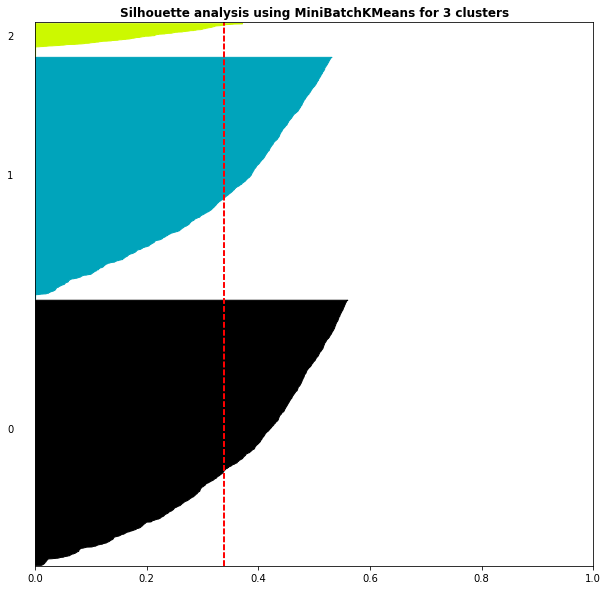

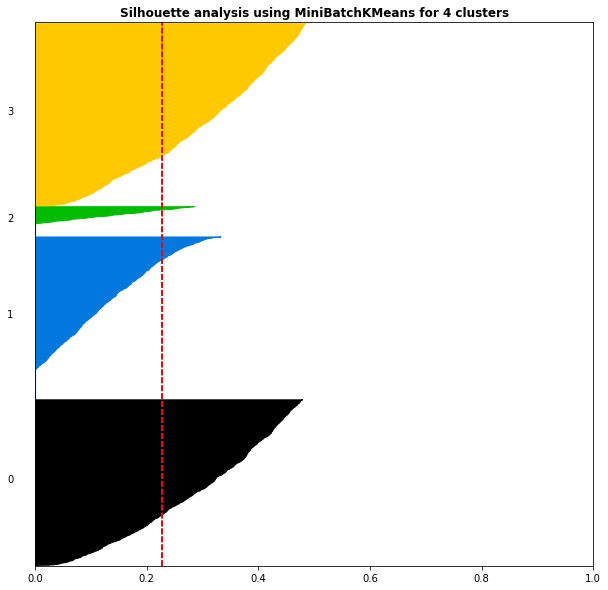

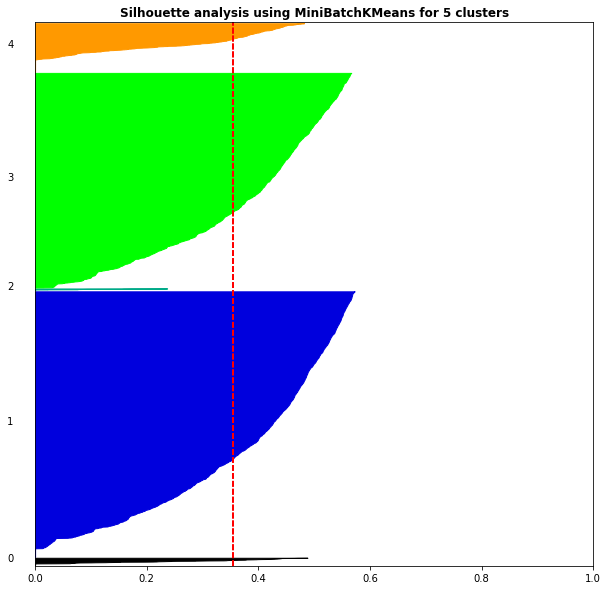

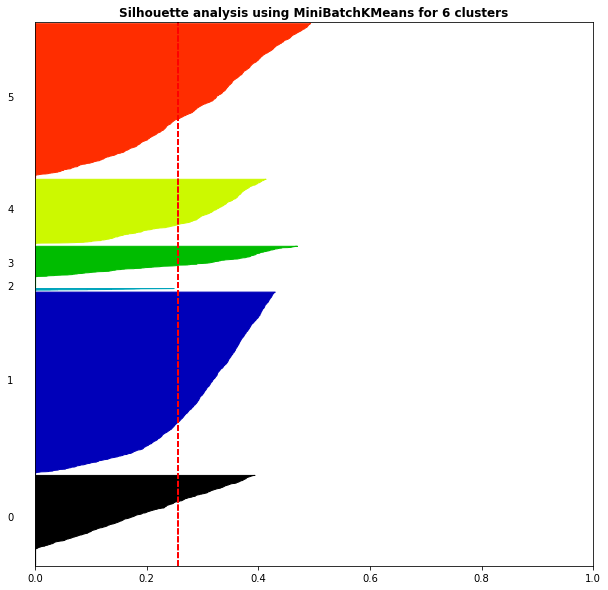

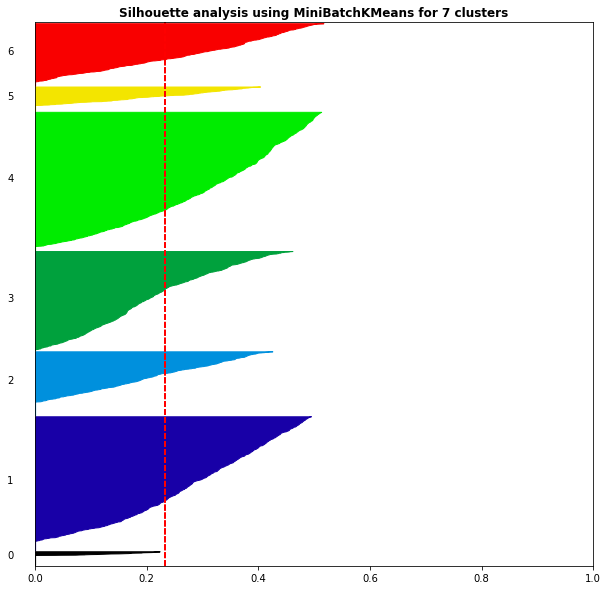

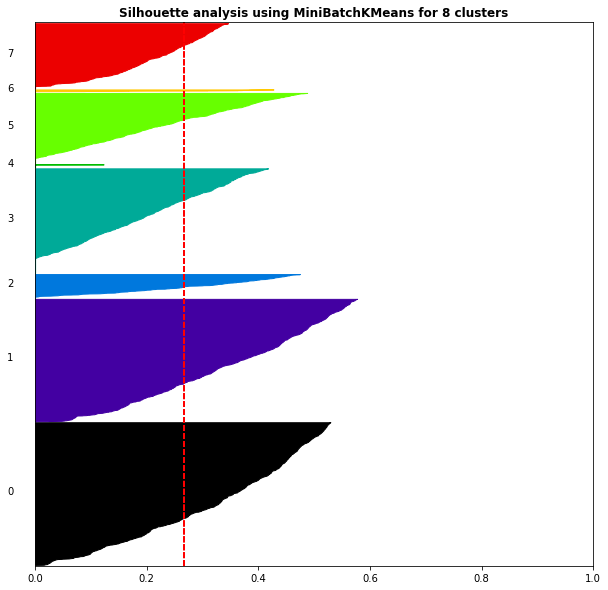

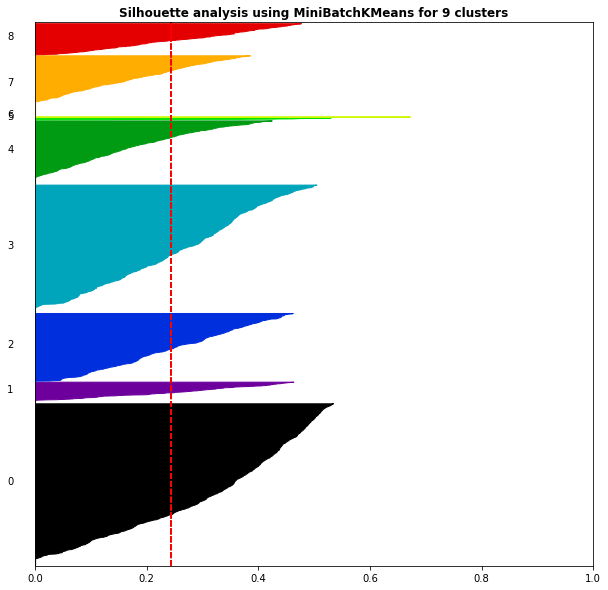

In [30]:
X = location_9.drop(columns = ['TransactionID_x', 'CustLocation', 'TransactionFrequency'])
X = ct.fit_transform(X)
plt_silhouette(clusters, MiniBatchKMeans)

For 2 clusters,
 the average silhouette score is 0.9449058897135374
For 3 clusters,
 the average silhouette score is 0.05204196173583537
For 4 clusters,
 the average silhouette score is 0.05688839027574178
For 5 clusters,
 the average silhouette score is -0.009545575292373607
For 6 clusters,
 the average silhouette score is 0.13342206327472944
For 7 clusters,
 the average silhouette score is -0.010868193161125974
For 8 clusters,
 the average silhouette score is 0.11723979835654845
For 9 clusters,
 the average silhouette score is 0.08998116535482659


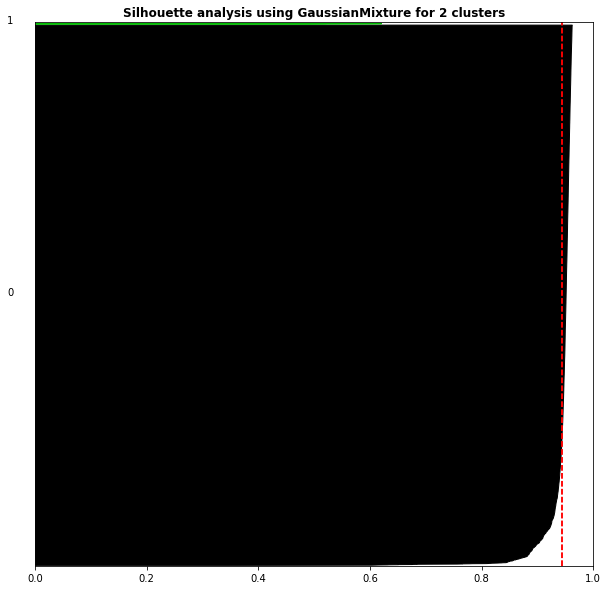

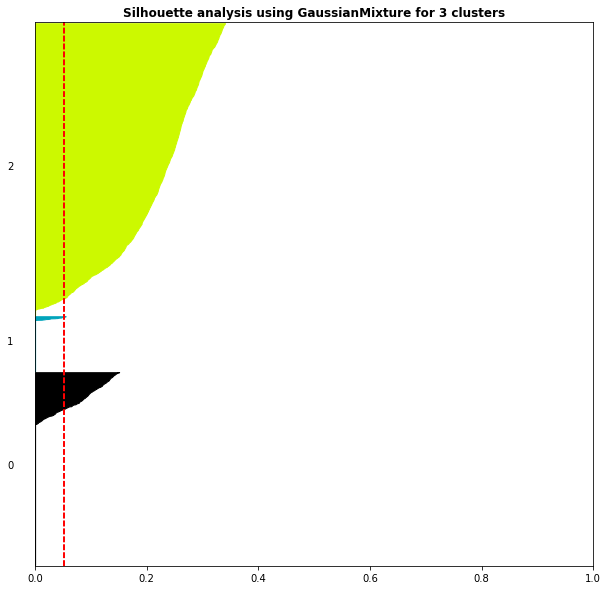

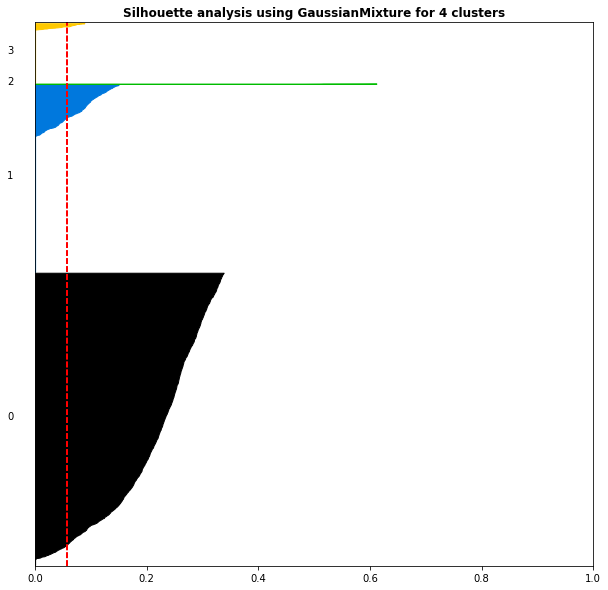

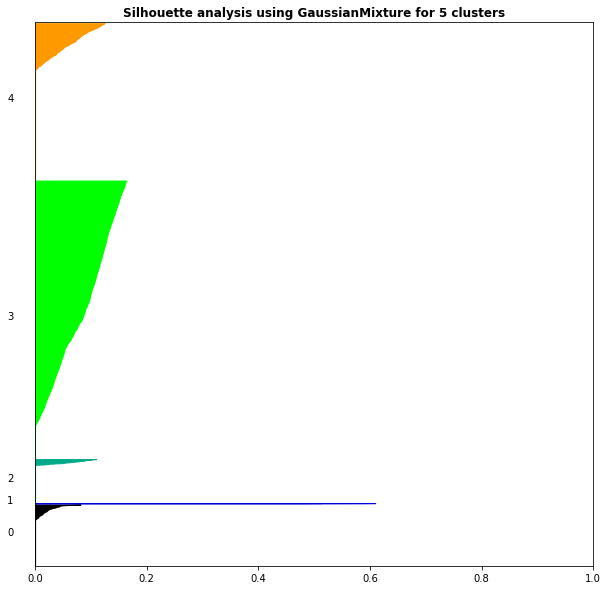

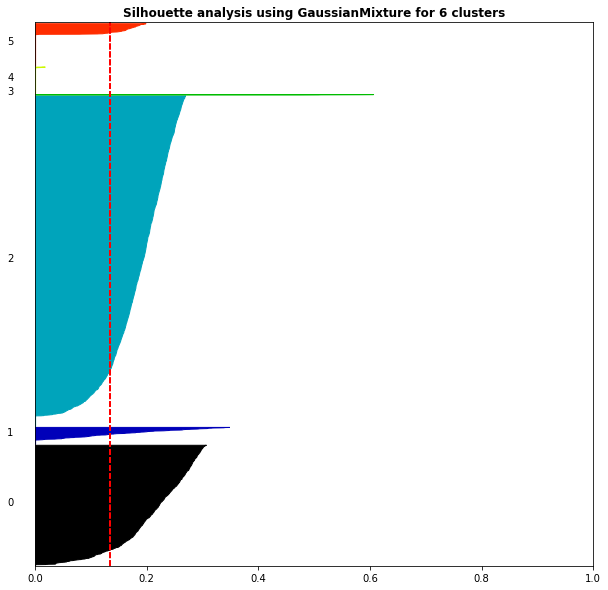

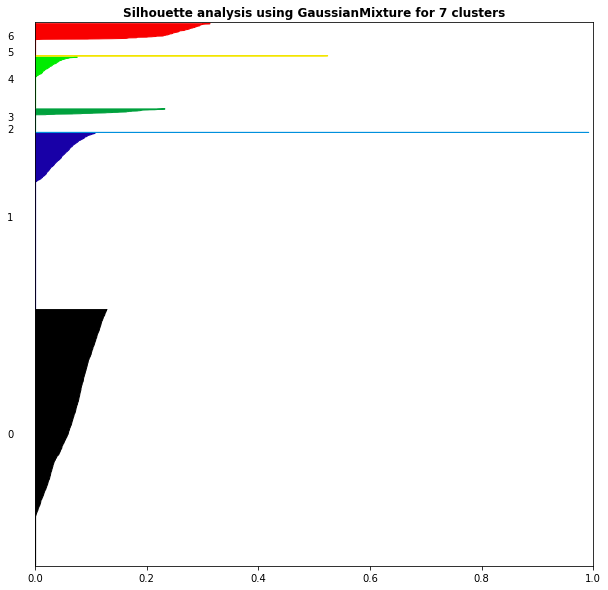

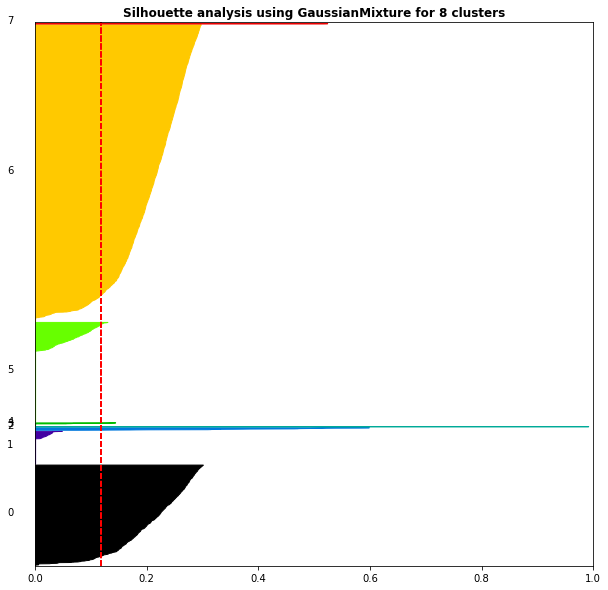

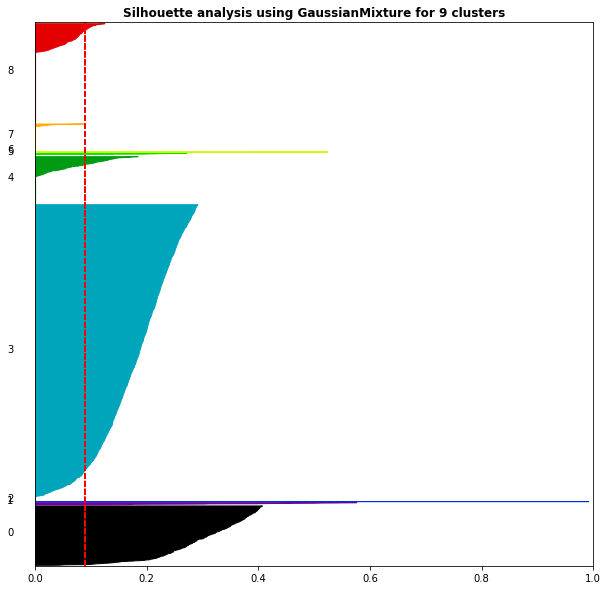

In [31]:
plt_silhouette(clusters, GaussianMixture)

Selecting Clusters is a little tough. Two clusters, if we include the transaction frequency could make sense since that should leave the clusters as people with only one transaction, and people with multiple transactions. KMF analysis showed that there is no practical difference between these groups, however (look at either recenvy vs total score. That leaves either three or four clusters while excluding the frequency. The issue with three clusters is that one of the clusters has a below average silhouette score, while with four clusters, we have one class that has significantly lower numbers. Let's see what both have to offer.

In [32]:
km3 = MiniBatchKMeans(n_clusters = 3)
km4 = MiniBatchKMeans(n_clusters = 4)

location_9['Three_Clusters'] = km3.fit_predict(X)
location_9['Four_Clusters'] = km4.fit_predict(X)

location_9.head()



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,TransactionID_x,CustGender,CustLocation,CustAccountBalance,AverageTransactionAmount,Age,Recency,TransactionFrequency,Three_Clusters,Four_Clusters
14,T11,0,9,48429.49,259.0,39.275460,80.0,2,1,2
43,T793207,0,9,6786.39,16.0,29.599696,46.0,2,0,3
352,T289,0,9,390.04,567.0,35.102889,0.0,1,0,3
384,T317,0,9,5802.91,695.0,51.511166,0.0,1,0,3
390,T322,0,9,176012.36,222.0,36.419823,0.0,1,0,3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


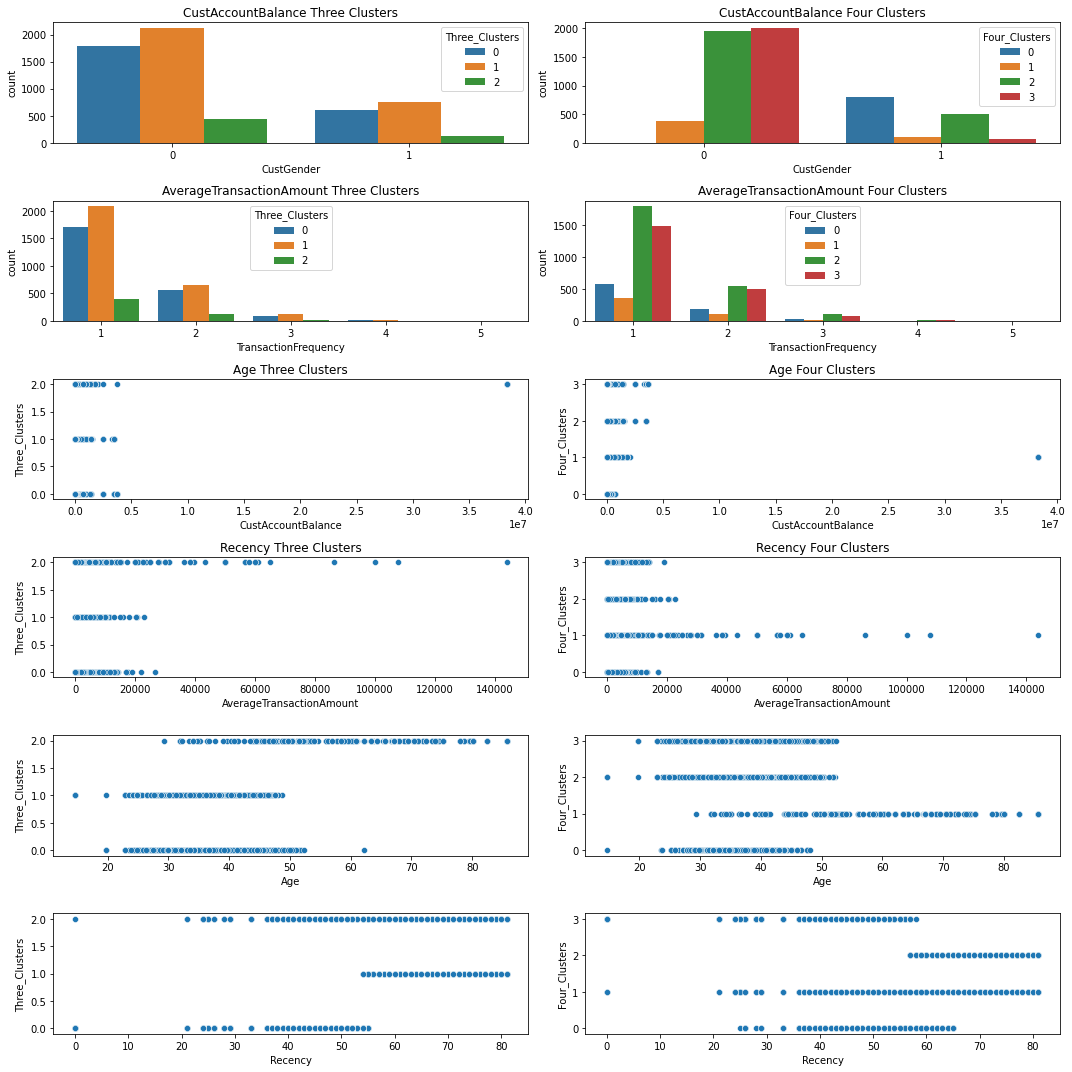

In [33]:
#location_9['CustGender'] = location_9['CustGender'].map(lambda x: 'F' if x == 1 else 'M')
location_9['TransactionFrequency'] = location_9['TransactionFrequency'].astype(int)
fig, axes = plt.subplots(6, 2, figsize = (15, 15))
axes = axes.flatten()

continuous_columns = location_9.drop(columns = ['TransactionID_x','CustLocation', 'Three_Clusters',
                                                'Four_Clusters', 'CustGender', 'TransactionFrequency']).columns

cat_columns = location_9[['CustGender', 'TransactionFrequency']]

for idx, c_name in enumerate(cat_columns):
    sns.countplot(x = c_name, hue = 'Three_Clusters',  data = location_9, ax = axes[2 * idx])
    sns.countplot(x = c_name, hue = 'Four_Clusters', data = location_9, ax = axes[2 * idx + 1])
    axes[2 * idx].set_title(f'{c_name} Three Clusters')
    axes[2 * idx + 1].set_title(f'{c_name} Four Clusters')

for idx, c_name in enumerate(continuous_columns):
    sns.scatterplot(y = 'Three_Clusters', x = c_name,  data = location_9, ax = axes[2 * (idx + 2)])
    sns.scatterplot(y = 'Four_Clusters', x = c_name, data = location_9, ax = axes[2 * (idx + 2) + 1])
    axes[2 * idx].set_title(f'{c_name} Three Clusters')
    axes[2 * idx + 1].set_title(f'{c_name} Four Clusters')
    
plt.tight_layout()

There's nothing really indicating what's different about the groups. For the four clusters, the gender ratio, and transaction frequency ratios look roughly the same across the clusters, ie the ratio of M : F in cluster 3 appears to be the same ratio as cluster 0. Cluster 0, 1, 3 have the same account balance, and average transaction amount, while cluster 2 has some values exceeding these values. Age is really the same, adn the only other major difference is the recency (DaysSinceTransaction), where cluster 3 has mostly low recencies (as in days, not score), cluster 0 has middling, cluster 1 has high recency, however cluster 2 is all over the place.

A somewhat similar story exists for the three cluster situation.